In [27]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import solve_ivp

scale = 0.75;
fsize = (12*scale, 9*scale)
mpl.rcParams['axes.titlesize'] = 26*scale
mpl.rcParams['legend.fontsize'] = 22*scale
mpl.rcParams['axes.labelsize'] = 20*scale
mpl.rcParams['lines.linewidth'] = 2*scale
mpl.rcParams['lines.markersize'] = 16*scale
mpl.rcParams['xtick.labelsize'] = 18*scale
mpl.rcParams['ytick.labelsize'] = 18*scale

def add_axes(ax):
    plt.plot([0,0],ax[2:4],'-k')
    plt.plot(ax[0:2],[0,0],'-k')

def bg_fill(ax):
    plt.axis(ax)
    x = np.linspace(ax[0],ax[1],50)
    yl = ax[2]
    yr = ax[3]
    plt.fill_between(x, 0*x + yl, 0*x + yr, alpha = 0.3, color='blue')

def auto_bounds(bdry):
    xl = 1.25*np.min(np.real(bdry))
    xr = 1.25*np.max(np.real(bdry))
    yl = 1.25*np.min(np.imag(bdry))
    yr = 1.25*np.max(np.imag(bdry))
    
    v = max(np.abs([xl,xr,yl,yr]))
    return [-v,v,-v,v]

### BDF stability regions

The BDF formula with $m$ steps has the form

$$ \sum_{j=0}^{m} a_ju_{n-j} = b_0hf_{n},$$

e.g. $u_n - \frac{4}{3}u_{n-1} + \frac{1}{3}u_{n-2} = \frac{2h}{3}f_n$ for $m=2.$

The coefficients for $1 \leq m \leq 4$ are (with $b$ listed last):
\begin{align*}
m=2:\quad  & 1, \, -1, \quad 1 \\
m=2:\quad  & 1, \, -4/3, \, 1/3, \quad 2/3 \\
m=3:\quad  &1, \, -18/11, \, 9/11, \, -2/11, \quad 6/11 \\
m=4:\quad  &1, \, -48/25, \, 36/25, \, -16/25, \, 3/25, \quad 12/25 
\end{align*}
Note that only the formulas for $m \leq 6$ are usable as they are not zero-stable for $m > 6$.

The stability regions $R$ are obtained using the condition that $z=h\lambda$ is on the boundary of $R$ if $r = e^{i\theta}$ is a zero of the characteristic polynomial, yielding
$$
    z(\theta) = \frac{\sum_{j=0}^m a_je^{i(m-j)\theta}}{b_0e^{im\theta}} = \frac{1}{b_0}\sum_{j=0}^m a_j e^{-ij\theta}
$$
which can be used to plot the stability region.

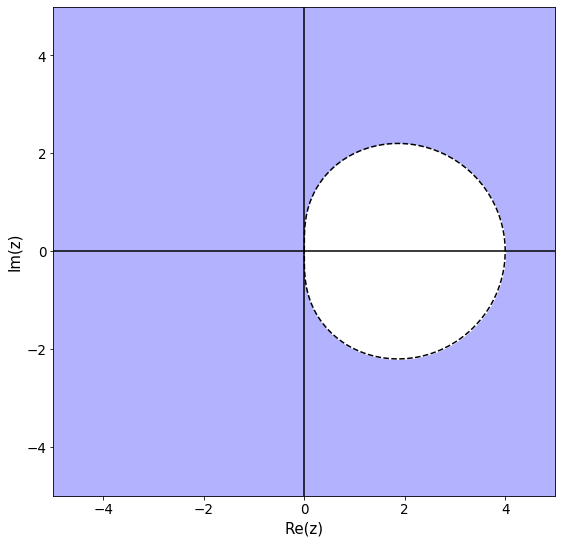

In [28]:
coeffs = [[1, -1, 1],
          [1,-4/3,1/3, 2/3],
          [1,-18/11, 9/11, -2/11, 6/11],
          [1, -48/25, 36/25, -16/25, 3/25, 12/25],
          [1, -300/137, 300/137, -200/137, 75/137, -12/137,  60/137],
          [1, -360/147, 450/147, -400/147, 225/147, -72/147, 10/147, 60/147]]

def bdf_bdry(ind, npts):
    t = np.linspace(0,2*np.pi,npts)
    bdry = np.zeros(npts, dtype='complex')

    for i in range(npts):
        for k in range(ind+1):
            bdry[i] += coeffs[ind-1][k]*np.exp(-1j*k*t[i])
        bdry[i] /= coeffs[ind-1][-1]
    return bdry

npts = 200
bdry = bdf_bdry(2, 200)
plt.figure(figsize=[fsize[0],fsize[0]])
plt.plot(np.real(bdry), np.imag(bdry),'--k')

ax = auto_bounds(bdry)
add_axes(ax)
plt.axis(ax)
bg_fill(ax) #fill entire region
plt.fill_between(np.real(bdry), 0, np.imag(bdry), alpha = 1, color='white'); #un-fill interior
plt.xlabel('Re(z)')
plt.ylabel('Im(z)');

### Adams-Bashforth/Moulton stability regions

The Adams-Bashforth methods have the form

$$u_{n+1} = u_n + h \sum_{j=0}^m b_jf_{n-j}$$

and the Adams-Moulton methods have the form

$$u_{n+1} = u_n + h \sum_{j=-1}^m b_jf_{n-j}$$

The Adams-Bashforth coefficients for $1 \leq m \leq 4$ are:
\begin{align*}
m=1:\quad  & 3/2, \, -1/2 \\
m=2:\quad  & 23/12, \, -16/12, \, 5/12 \\
m=3:\quad  & 55/24, \, -59/24, \, 37/24, \, -9/24 \\
m=4:\quad & 1901/720, \, -2774/720, \, 2616/720, \, -1274/720, \, 251/720
\end{align*}

The Adams-Moulton coefficients for $1 \leq m \leq 4$ are:
\begin{align*}
m=1:\quad & 1/2 \, 1/2 \\
m=2:\quad  & 5/12, \, 2/3, \, -1/12 \\
m=3:\quad  & 9/24, \, 19/24, \, -5/24, \, 1/24 \\
m=4:\quad  & 251/720, \, 646/720, \, -264/720, \, 106/720, \, -19/720
\end{align*}

The stability region [see lecture notes] has the boundary

$$ z(\theta) = \frac{e^{i(m+1)\theta} - e^{im\theta}}{\sum_{j=-1}^m b_j e^{i(m+1-j)\theta}}$$

In [29]:
ab_coeffs = [[0, 1],
             [0, 3/2, -1/2], 
            [0, 23/12, -16/12, 5/12],
            [0, 55/24, -59/24, 37/24, -9/24],
            [0, 1901/720, -2774/720, 2616/720, -1274/720, 251/720]]
am_coeffs = [[1/2, 1/2], 
            [5/12, 8/12, -1/12],
            [9/24, 19/24, -5/24, 1/24],
            [251/720, 646/720, -264/720, 106/720, -19/720]]

def am_bdry(ind, npts):
    t = np.linspace(0,2*np.pi,npts)
    bdry = np.zeros(npts, dtype='complex')

    for i in range(npts):
        for k in range(ind+2):
            bdry[i] += am_coeffs[ind][k]*np.exp(1j*(ind+ 1 - k)*t[i])
        bdry[i] = (np.exp(1j*(ind+1)*t[i]) - np.exp(1j*ind*t[i]))/bdry[i]
    
    return bdry

def ab_bdry(ind, npts):
    t = np.linspace(0,2*np.pi,npts)
    bdry = np.zeros(npts, dtype='complex')

    for i in range(npts):
        for k in range(ind+2):
            bdry[i] += ab_coeffs[ind][k]*np.exp(1j*(ind+ 1 - k)*t[i])
        bdry[i] = (np.exp(1j*(ind+1)*t[i]) - np.exp(1j*ind*t[i]))/bdry[i]
    
    return bdry

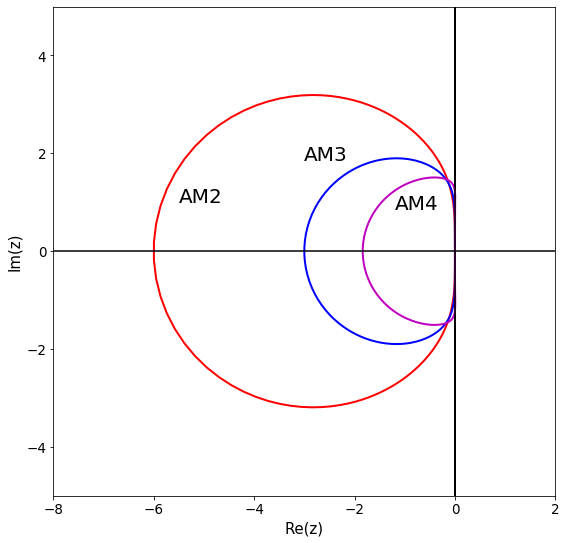

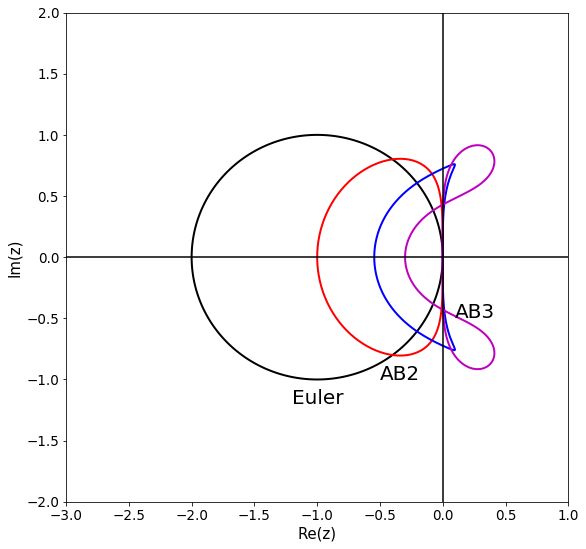

In [31]:
# AM plot:
plt.figure(figsize=[fsize[0],fsize[0]])
styles = ['-k','-r','-b','-m']
for ind in range(0,4):
    bdry = am_bdry(ind,200)
    plt.plot(np.real(bdry), np.imag(bdry),styles[ind],linewidth=2)
ax = [-8, 2, -5, 5]
plt.axis(ax);
add_axes(ax)
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
fs = 20
plt.annotate('AM2',(-5.5,1),fontsize=fs)
plt.annotate('AM3',(-3,1.85),fontsize=fs)
plt.annotate('AM4',(-1.2,0.85),fontsize=fs)

# AB plot:
plt.figure(figsize=[fsize[0],fsize[0]])
styles = ['-k','-r','-b','-m']
for ind in range(0,4):
    bdry = ab_bdry(ind,200)
    plt.plot(np.real(bdry), np.imag(bdry),styles[ind],linewidth=2)
ax = [-3, 1, -2, 2]
plt.axis(ax);
add_axes(ax)
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
fs
plt.annotate('Euler',(-1.2,-1.2),fontsize=fs)
plt.annotate('AB2',(-0.5,-1),fontsize=fs)
plt.annotate('AB3',(0.1,-0.5),fontsize=fs);

### RK stability regions

The stability region for an $m$-stage, order $m$ RK method ($1 \leq m \leq 4$) has the form

$$|1 + z + \cdots + \frac{1}{p!}z^p| < 1.$$

Note that for $m > 4$ or methods with order $\neq$ number of stages, the region is different.

The region is plotted by setting the factor $q(z)$ in $|q(z)| < 1$ equal to $e^{i\theta}$, then solving for $z$. By incrementing $\theta$ by a small amount each time and using Newton's method, we can construct the curve.

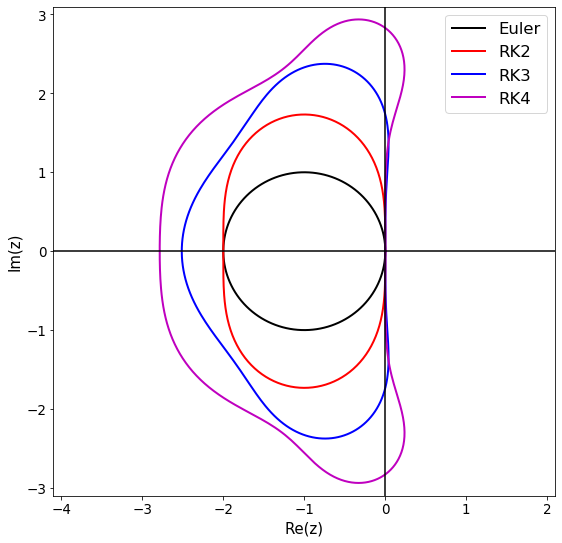

In [32]:
def newton(f, df, x0, tol, max_iter=50, tolf=1e-20):
    x = x0
    it = 0
    err = 2*tol
    while it < max_iter and err > tol:
        fx = f(x)
        delta = -fx/df(x)
        x += delta
        it += 1
        err = abs(delta)
    return x, it

def e_series(z,ind):
    y = 1.0
    for k in range(1,ind+1):
        y += z**k/math.factorial(k)
    return y 

def rk_bdry(ind, npts):
    t = np.linspace(0, 2*ind*np.pi, npts)
    bdry = np.zeros(npts, dtype='complex')

    bdry[0] = 0 #start at the origin
    guess = bdry[0]
    for i in range(1, npts):
        func = lambda z: e_series(z,ind) - np.exp(1j*t[i])
        dfunc = lambda z: e_series(z,ind-1)
        
        bdry[i], it = newton(func, dfunc, guess, 1e-12)
        guess = bdry[i] + (bdry[i]-bdry[i-1])
    
    return bdry

# RK plot:
plt.figure(figsize=[fsize[0],fsize[0]])
styles = ['-k','-r','-b','-m']
for ind in range(1,5):
    bdry = rk_bdry(ind,400)
    plt.plot(np.real(bdry), np.imag(bdry),styles[ind-1],linewidth=2)
ax = [-4.1, 2.1, -3.1, 3.1]
plt.axis(ax);
add_axes(ax)
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.legend(['Euler','RK2','RK3','RK4']);